<a href="https://colab.research.google.com/github/TacticalCoders/2022-kisti/blob/main/kisiti_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 필요한 패키지 설치

In [1]:
# pytorch 1.8.1 설치
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
!pip install config

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install konlpy==0.5.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### mecab 설치
kisti 전용 토크나이저를 사용하기 위해 설치 필요

In [6]:
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Fetched 261 kB in 2s (138 kB/s)
Reading package lis

## 구글 드라이브 마운트

데이터셋, 어휘사전 등의 파일을 위해 구글 드라이브 마운트

In [7]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### import

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

import os
import config
from tqdm import tqdm
import json

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
#from seqeval.metrics import precision_score, recall_score, f1_score

import numpy as np
from tqdm import tqdm
import argparse

import transformers
from transformers import AutoConfig, AutoModel, AutoTokenizer
from transformers.optimization import AdamW, get_linear_schedule_with_warmup

## config.py

In [9]:
# root_dir = os.path.dirname(os.path.abspath(__file__))
# root_dir = os.path.abspath('') # 현재 스크립트가 실행되는 위치
# cache_dir = os.path.join(root_dir, "cache")
# output_dir = os.path.join(root_dir, "학습된 모델 파일 이름") # 저장할 파일 이름 지정
# data_dir = os.path.join(root_dir, "data")
root_dir = '/content/drive/MyDrive/kisti_baseline'
cache_dir = root_dir + "/cache"
output_dir = root_dir + "/학습된 모델 파일 이름" # 추후 저장될 모델의 이름 지정해야 함
data_dir = root_dir + "/data"

In [10]:
print("root_dir:", root_dir)
print("cache_dir:", cache_dir)
print("output_dir:", output_dir)
print("data_dir:",data_dir)

root_dir: /content/drive/MyDrive/kisti_baseline
cache_dir: /content/drive/MyDrive/kisti_baseline/cache
output_dir: /content/drive/MyDrive/kisti_baseline/학습된 모델 파일 이름
data_dir: /content/drive/MyDrive/kisti_baseline/data


In [11]:
# root_dir로 실행위치 이동
%cd /content/drive/MyDrive/kisti_baseline

/content/drive/MyDrive/kisti_baseline


## Mecab에 사용자 사전 추가



*   pap_all_mecab_dic.csv
*   pat_all_mecab_dic.csv

을 /tmp/mecab-ko-dic-2.1.1-20180720으로 복사.

참고로 kisti_tokenization에 mecab 경로 역시 /tmp/mecab-ko-dic-2.1.1-20180720으로 지정했음.


In [12]:
%cp pap_all_mecab_dic.csv /tmp/mecab-ko-dic-2.1.1-20180720
%cp pat_all_mecab_dic.csv /tmp/mecab-ko-dic-2.1.1-20180720

## preprocessing.py

데이터셋을 읽어와서 토큰화 진행 후 데이터셋 클래스로 반환.

다만 2022년에는 kisti에서 지정한 토크나이저를 이용해야 하므로 수정함.

이전 토크나이저는 단어 단위("sentence")로 토크나이저에 입력, 하지만 kisti 토크나이저는 문장("origin_sent")만 넣어주면 되므로 이에 맞게 수정.

In [13]:
"""
  입력 문장, 대분류, 세부분류 태그를 전처리 코드
"""

fine_vocab_path = data_dir + "/fine_vocab.txt"
coarse_vocab_path = data_dir + "/coarse_vocab.txt"

fine_vocab_map_str = {}
coarse_vocab_map_str = {}

with open(fine_vocab_path, 'r', encoding='utf-8') as vocab:
    for label in vocab:
        label = label.strip()
        fine_vocab_map_str[label] = len(fine_vocab_map_str)
print(fine_vocab_map_str)

with open(coarse_vocab_path, 'r', encoding='utf-8') as vocab:
    for label in vocab:
        label = label.strip()
        coarse_vocab_map_str[label] = len(coarse_vocab_map_str)
print(coarse_vocab_map_str)

# 학습 or 평가 데이터를 읽어 리스트에 저장
def read_data(file_path, mode):
    datas = []
    with open(file_path, "r", encoding="utf8") as json_file:
        for index, json_line in enumerate(tqdm(json_file, desc='read_data')):
            json_data = json.loads(json_line)

            origin_sent = json_data["sentence"]
            # sentence = json_data["sentence"].split(" ")
            sentence = ""
            coarse_tag = json_data["coarse_tag"]
            fine_tag = json_data["fine_tag"]

            coarse_tag = coarse_vocab_map_str[coarse_tag]
            fine_tag = fine_vocab_map_str[fine_tag]

            datas.append((origin_sent, sentence, fine_tag, coarse_tag))

    return datas


def convert_data2dataset(datas, tokenizer, max_length, coarse_tags, fine_tags, mode):
    total_input_ids, total_attention_mask, total_token_type_ids, total_coarse_tags, total_coarse_seq, total_fine_tags, total_fine_seq, total_word_seq = [], [], [], [], [], [], [], []

    if mode == "analyze":
        total_fine_tags = None

    for index, data in enumerate(tqdm(datas, desc="convert_data2dataset")):
        sentence = []
        fine_tag = []
        coarse_tag = []

        if mode == "train" or mode == "test":
            origin_sent, sentence, fine_tag, coarse_tag = data

        tokens = []
        fine_ids = []

        # for word in sentence: # 여기서 sentence는 공백으로 split된 단어들의 리스트임.
        #     word_tokens = tokenizer.tokenize(word.lower())
        #     tokens.extend(word_tokens)

        tokens = tokenizer.tokenize(origin_sent)

        tokens = ["[CLS]"] + tokens
        tokens = tokens[:max_length-1]
        tokens.append("[SEP]")

        input_ids = sum([tokenizer.convert_tokens_to_ids([token]) for token in tokens],[])

        assert len(input_ids) <= max_length

        attention_mask = [1] * len(input_ids)
        token_type_ids = [0] * len(input_ids)

        padding = [0] * (max_length - len(input_ids))

        total_word_seq.append(len(input_ids))

        input_ids += padding
        attention_mask += padding
        token_type_ids += padding

        total_input_ids.append(input_ids)
        total_attention_mask.append(attention_mask)
        total_token_type_ids.append(token_type_ids)

        total_coarse_seq.append([i for i in range(coarse_tags)])
        total_fine_seq.append([i for i in range(fine_tags)])

        total_coarse_tags.append(coarse_tag)
        total_fine_tags.append(fine_tag)

    total_input_ids = torch.tensor(total_input_ids, dtype=torch.long)
    total_attention_mask = torch.tensor(total_attention_mask, dtype=torch.long)
    total_token_type_ids = torch.tensor(total_token_type_ids, dtype=torch.long)

    total_coarse_seq = torch.tensor(total_coarse_seq, dtype=torch.long)
    total_fine_seq = torch.tensor(total_fine_seq, dtype=torch.long)

    total_word_seq = torch.tensor(total_word_seq, dtype=torch.long)

    if mode == "train" or mode == "test":
        total_coarse_tags = torch.tensor(total_coarse_tags, dtype=torch.long)
        total_fine_tags = torch.tensor(total_fine_tags, dtype=torch.long)

        dataset = TensorDataset(total_input_ids, total_attention_mask, total_token_type_ids, total_coarse_tags,
                            total_coarse_seq, total_fine_tags, total_fine_seq, total_word_seq)
        
    return dataset


{'문제 정의': 0, '가설 설정': 1, '기술 정의': 2, '제안 방법': 3, '대상 데이터': 4, '데이터처리': 5, '이론/모형': 6, '성능/효과': 7, '후속연구': 8}
{'연구 목적': 0, '연구 방법': 1, '연구 결과': 2}


## model.py

2021 수상작에서 설계한 모델

In [14]:
"""
    대분류/세부분류 모델
"""
class SequenceClassification(nn.Module):
    def __init__(self, config, model, coarse_emb_size, coarse_size, fine_emb_size, fine_size, lstm_hidden, num_layer, bilstm_flag):
        super().__init__()
        self.config = config

        self.model = model

        assert fine_emb_size == lstm_hidden * 2, "Please set score-embedding-size to twice the lstm-hidden-size"

        # 분류할 라벨의 개수
        #self.num_labels = config.num_labels

        self.n_hidden = lstm_hidden

        self.coarse_emb = nn.Embedding(coarse_size, coarse_emb_size, scale_grad_by_freq=True)
        self.fine_emb = nn.Embedding(fine_size, fine_emb_size, scale_grad_by_freq=True)

        self.num_layers = num_layer
        self.bidirectional = 2 if bilstm_flag else 1

        self.coarse_label_lstm_first = nn.LSTM(config.hidden_size, self.n_hidden, bidirectional=True, batch_first=True)
        self.coarse_label_lstm_last = nn.LSTM(lstm_hidden * 4, self.n_hidden, num_layers=self.num_layers, batch_first=True, bidirectional=bilstm_flag)

        ## 사전학습 언어모델 : base = lstm_hidden * 5 / large = lstm_hidden * 6
        self.fine_label_lstm_first = nn.LSTM(lstm_hidden * 5, self.n_hidden, bidirectional=True, batch_first=True)

        self.fine_label_lstm_last = nn.LSTM(lstm_hidden * 4, self.n_hidden, num_layers=self.num_layers, batch_first=True, bidirectional=bilstm_flag)

        self.coarse_q_liner = nn.Linear(self.n_hidden * 2, self.n_hidden * 2)
        self.coarse_k_liner = nn.Linear(self.n_hidden * 2, self.n_hidden * 2)
        self.coarse_v_liner = nn.Linear(self.n_hidden * 2, self.n_hidden * 2)

        self.fine_q_liner = nn.Linear(self.n_hidden * 2, self.n_hidden * 2)
        self.fine_k_liner = nn.Linear(self.n_hidden * 2, self.n_hidden * 2)
        self.fine_v_liner = nn.Linear(self.n_hidden * 2, self.n_hidden * 2)

        self.dropout = nn.Dropout(config.hidden_dropout_prob)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, coarse_labels=None, coarse_label_seq_tensor=None, fine_labels=None, fine_label_seq_tensor=None, word_seq_lengths=None):

        discriminator_hidden_states = self.model(input_ids, attention_mask)

        # (batch_size, max_length, hidden_size)
        discriminator_hidden_states = discriminator_hidden_states[0]

        coarse_embs = self.coarse_emb(coarse_label_seq_tensor)
        fine_embs = self.fine_emb(fine_label_seq_tensor)

        hidden = None
        scaler = self.n_hidden ** 0.5

        """
        coarse tag predict layer
        """
        coarse_lstm_outputs, hidden = self.coarse_label_lstm_first(discriminator_hidden_states, hidden)
        coarse_lstm_outputs = self.dropout(coarse_lstm_outputs)

        coarse_q = self.coarse_q_liner(coarse_lstm_outputs)
        coarse_k = self.coarse_k_liner(coarse_embs)
        coarse_v = self.coarse_v_liner(coarse_embs)

        coarse_attention_score = coarse_q.matmul(coarse_k.permute(0, 2, 1)) / scaler
        coarse_attention_align = self.softmax(coarse_attention_score)

        coarse_attention_output = coarse_attention_align.matmul(coarse_v)
        coarse_attention_output = self.dropout(coarse_attention_output)

        coarse_lstm_outputs = torch.cat([coarse_lstm_outputs, coarse_attention_output], dim=-1)
        coarse_lstm_outputs, hidden = self.coarse_label_lstm_last(coarse_lstm_outputs, hidden)
        coarse_lstm_outputs = self.dropout(coarse_lstm_outputs)

        coarse_q = self.coarse_q_liner(coarse_lstm_outputs)
        coarse_k = self.coarse_k_liner(coarse_embs)

        coarse_attention_score = coarse_q.matmul(coarse_k.permute(0, 2, 1)) / scaler
        coarse_attention_score = self.dropout(coarse_attention_score)

        final_coarse_attention_score = coarse_attention_score[:, 0, :]

        """
        coarse tag & fine tag concat
        """
        coarse_attention_score = coarse_attention_score.matmul(coarse_embs) # [batch_size, max_length, max_length]
        coarse_attention_score = torch.cat([discriminator_hidden_states, coarse_attention_score], dim=-1)

        """
        fine tag predict layer
        """
        fine_lstm_outputs, hidden = self.fine_label_lstm_first(coarse_attention_score, hidden)
        fine_lstm_outputs = self.dropout(fine_lstm_outputs)

        fine_q = self.fine_q_liner(fine_lstm_outputs)  # [batch_size, max_length]
        fine_k = self.fine_k_liner(fine_embs)  # [batch_size, tag_size, max_length]
        fine_v = self.fine_v_liner(fine_embs)  # [tag_size, max_length]

        fine_attention_score = fine_q.matmul(fine_k.permute(0, 2, 1)) / scaler
        fine_attention_align = self.softmax(fine_attention_score)  # [batch_size, tag_size]

        fine_attention_output = fine_attention_align.matmul(fine_v)
        fine_attention_output = self.dropout(fine_attention_output)  # [batch_size, max_length]

        fine_lstm_outputs = torch.cat([fine_lstm_outputs, fine_attention_output], dim=-1)
        fine_lstm_outputs, hidden = self.fine_label_lstm_last(fine_lstm_outputs, hidden)
        fine_lstm_outputs = self.dropout(fine_lstm_outputs)

        fine_q = self.fine_q_liner(fine_lstm_outputs)
        fine_k = self.fine_k_liner(fine_embs)

        fine_attention_score = fine_q.matmul(fine_k.permute(0, 2, 1)) / scaler
        fine_attention_score = self.dropout(fine_attention_score)
        final_fine_attention_score = fine_attention_score[:, 0, :]

        return final_coarse_attention_score, final_fine_attention_score

## main_fuctions.py

In [15]:
import tokenization_kisti as tokenization

def get_score(predicts, corrects, idx2label):

    result = {}

    def get_score_one_class(predicts, corrects, value):
        TP, FP, FN, TN = 0, 0, 0, 0

        for correct, predict in zip(corrects, predicts):

            if (correct == value and predict == value):
                TP += 1
            elif (correct != value and predict == value):
                FP += 1
            elif (correct == value and predict != value):
                FN += 1
            elif (correct != value and predict != value):
                TN += 1

        if (TP == 0):
            precision, recall, f1_score, accuracy = 0, 0, 0, 0
        else:
            precision = float(TP) / (TP + FP)
            recall = float(TP) / (TP + FN)
            f1_score = (2 * precision * recall) / (precision + recall)
            accuracy = float(TP + TN) / (TP + FN + FP + TN)

        return precision, recall, f1_score, accuracy, TP, FP, FN, TN

    values = list(idx2label.values())

    for value in values:
        precision, recall, f1_score, accuracy, TP, FP, FN, TN = get_score_one_class(predicts, corrects, value)
        result[value] = {"precision": precision, "recall": recall, "f1_score": f1_score, "accuracy": accuracy,
                         "TP": TP, "FP": FP, "FN": FN, "TN": TN}

    macro_precision = np.sum([result[value]["precision"] for value in values]) / len(values)
    macro_recall = np.sum([result[value]["recall"] for value in values]) / len(values)
    macro_f1_score = np.sum([result[value]["f1_score"] for value in values]) / len(values)
    total_accuracy = np.sum([result[value]["accuracy"] for value in values]) / len(values)

    total_TP = np.sum([result[value]["TP"] for value in values])
    total_FP = np.sum([result[value]["FP"] for value in values])
    total_FN = np.sum([result[value]["FN"] for value in values])
    total_TN = np.sum([result[value]["TN"] for value in values])

    if (total_TP == 0):
        micro_precision, micro_recall, micro_f1_score, accuracy = 0, 0, 0, 0
    else:
        micro_precision = float(total_TP) / (total_TP + total_FP)
        micro_recall = float(total_TP) / (total_TP + total_FN)
        micro_f1_score = (2 * micro_precision * micro_recall) / (micro_precision + micro_recall)

    for value in values:
        precision, recall, f1_score = result[value]["precision"], result[value]["recall"], result[value]["f1_score"]
        TP, FP, FN, TN = result[value]["TP"], result[value]["FP"], result[value]["FN"], result[value]["TN"]

        print("Precision from {} : ".format(value) + str(round(precision, 4)))
        print("Recall from {} : ".format(value) + str(round(recall, 4)))
        print("F1_score from {} : ".format(value) + str(round(f1_score, 4)))
        print("Accuracy from {} : ".format(value) + str(round(total_accuracy, 4)))
        print()

    return {"macro_precision": round(macro_precision, 4), "macro_recall": round(macro_recall, 4),
            "macro_f1_score": round(macro_f1_score, 4),
            "accuracy": round(total_accuracy, 4),
            "micro_precision": round(micro_precision, 4), "micro_recall": round(micro_recall, 4),
            "micro_f1": round(micro_f1_score, 4)}

class Helper():
    def __init__(self, config):
        self.config = config

    def do_train(self, model, optimizer, scheduler, train_dataloader, epoch, global_step):
        criterion = nn.CrossEntropyLoss()

        coarse_map = self.config["coarse_map"]
        fine_map = self.config["fine_map"]

        # batch 단위 별 loss를 담을 리스트
        losses = []

        # 모델의 출력 결과와 실제 정답값을 담을 리스트
        total_coarse_pred_label, total_coarse_gold_label = None, None
        total_fine_pred_label, total_fine_gold_label = None, None

        total_coarse_pred, total_coarse_correct = 0, 0
        total_fine_pred, total_fine_correct = 0, 0
        total_coarse_fine_pred, total_coarse_fine_correct = 0, 0

        for step, batch in enumerate(tqdm(train_dataloader, desc="do_train(epoch_{})".format(epoch))):
            batch = tuple(t.cuda() for t in batch)

            input_ids, attention_mask, token_type_ids, coarse_labels, coarse_seq, fine_labels, fine_seq, word_len_seq = \
                batch[0], batch[1], batch[2], batch[3], batch[4], batch[5], batch[6], batch[7]

            # 입력 데이터에 대한 출력과 loss 생성
            coarse_logits, fine_logits = model(input_ids, attention_mask, token_type_ids, coarse_labels, coarse_seq,
                                               fine_labels, fine_seq, word_len_seq)

            coarse_loss = criterion(coarse_logits, coarse_labels)
            coarse_pred = F.softmax(coarse_logits, dim=1)
            coarse_pred = coarse_pred.argmax(dim=1)

            fine_loss = criterion(fine_logits, fine_labels)
            fine_pred = F.softmax(fine_logits, dim=1)
            fine_pred = fine_pred.argmax(dim=1)

            for pred, gold in zip(coarse_pred, coarse_labels):
                if pred == gold:
                    total_coarse_correct += 1
                total_coarse_pred += 1

            for pred, gold in zip(fine_pred, fine_labels):
                if pred == gold:
                    total_fine_correct += 1
                total_fine_pred += 1

            for c_pred, c_gold, f_pred, f_gold in zip(coarse_pred, coarse_labels, fine_pred, fine_labels):
                if c_pred == c_gold and f_pred == f_gold:
                    total_coarse_fine_correct += 1
                total_coarse_fine_pred += 1

            if total_coarse_pred_label is None:
                total_coarse_pred_label = coarse_pred.detach().cpu().numpy()
                total_coarse_gold_label = coarse_labels.detach().cpu().numpy()
            else:
                total_coarse_pred_label = np.append(total_coarse_pred_label, coarse_pred.detach().cpu().numpy(), axis=0)
                total_coarse_gold_label = np.append(total_coarse_gold_label, coarse_labels.detach().cpu().numpy(),
                                                    axis=0)

            if total_fine_pred_label is None:
                total_fine_pred_label = fine_pred.detach().cpu().numpy()
                total_fine_gold_label = fine_labels.detach().cpu().numpy()
            else:
                total_fine_pred_label = np.append(total_fine_pred_label, fine_pred.detach().cpu().numpy(), axis=0)
                total_fine_gold_label = np.append(total_fine_gold_label, fine_labels.detach().cpu().numpy(), axis=0)

            total_loss = fine_loss + coarse_loss

            if self.config["gradient_accumulation_steps"] > 1:
                total_loss = total_loss / self.config["gradient_accumulation_steps"]
            if step % 300 == 0:
                print("\tloss : ", '{:.6f}'.format(total_loss))

            # loss 값으로부터 모델 내부 각 매개변수에 대하여 gradient 계산
            total_loss.backward()
            losses.append(total_loss.data.item())

            if (step + 1) % self.config["gradient_accumulation_steps"] == 0 or \
                    (len(train_dataloader) <= self.config["gradient_accumulation_steps"] and (step + 1) == len(
                        train_dataloader)):
                torch.nn.utils.clip_grad_norm_(model.parameters(), self.config["max_grad_norm"])

                # 모델 내부 각 매개변수 가중치 갱신
                optimizer.step()
                scheduler.step()

                # 변화도를 0으로 변경
                model.zero_grad()
                global_step += 1

        # 정확도 계산
        coarse_acc = total_coarse_correct / total_coarse_pred
        fine_acc = total_fine_correct / total_fine_pred
        coarse_fine_acc = total_coarse_fine_correct / total_coarse_fine_pred

        coarse_pred_label_list = [[] for _ in range(total_coarse_gold_label.shape[0])]
        coarse_gold_label_list = [[] for _ in range(total_coarse_gold_label.shape[0])]

        for i in range(total_coarse_gold_label.shape[0]):
            coarse_gold_label_list[i].append(coarse_map[total_coarse_gold_label[i]])
            coarse_pred_label_list[i].append(coarse_map[total_coarse_pred_label[i]])

        # coarse_precision = precision_score(coarse_gold_label_list, coarse_pred_label_list, suffix=True)
        # coarse_recall = recall_score(coarse_gold_label_list, coarse_pred_label_list, suffix=True)
        # coarse_f1 = f1_score(coarse_gold_label_list, coarse_pred_label_list, suffix=True)

        coarse_precision = precision_score(coarse_gold_label_list, coarse_pred_label_list, average='macro')
        coarse_recall = recall_score(coarse_gold_label_list, coarse_pred_label_list, average='macro')
        coarse_f1 = f1_score(coarse_gold_label_list, coarse_pred_label_list, average='macro')

        fine_pred_label_list = [[] for _ in range(total_fine_gold_label.shape[0])]
        fine_gold_label_list = [[] for _ in range(total_fine_gold_label.shape[0])]

        for i in range(total_fine_gold_label.shape[0]):
            fine_gold_label_list[i].append(fine_map[total_fine_gold_label[i]])
            fine_pred_label_list[i].append(fine_map[total_fine_pred_label[i]])

        # fine_precision = precision_score(fine_gold_label_list, fine_pred_label_list, suffix=True)  # 예측한 것 중, 정답의 비율
        # fine_recall = recall_score(fine_gold_label_list, fine_pred_label_list, suffix=True)  # 찾아야할 것 중, 실제로 찾은 비율
        # fine_f1 = f1_score(fine_gold_label_list, fine_pred_label_list, suffix=True)  # precision과 recall의 평균

        fine_precision = precision_score(fine_gold_label_list, fine_pred_label_list, average='macro')  # 예측한 것 중, 정답의 비율
        fine_recall = recall_score(fine_gold_label_list, fine_pred_label_list, average='macro')  # 찾아야할 것 중, 실제로 찾은 비율
        fine_f1 = f1_score(fine_gold_label_list, fine_pred_label_list, average='macro')  # precision과 recall의 평균

        return coarse_fine_acc, coarse_acc, coarse_precision, coarse_recall, coarse_f1, fine_acc, np.mean(
            losses), global_step, fine_precision, fine_recall, fine_f1

    def do_evaluate(self, model, test_dataloader, mode):

        coarse_map = self.config["coarse_map"]
        fine_map = self.config["fine_map"]

        # 모델의 입력, 출력, 실제 정답값을 담을 리스트
        total_input_ids = []

        total_coarse_pred_label, total_coarse_gold_label = None, None
        total_fine_pred_label, total_fine_gold_label = None, None

        total_coarse_pred, total_coarse_correct = 0, 0
        total_fine_pred, total_fine_correct = 0, 0
        total_coarse_fine_pred, total_coarse_fine_correct = 0, 0

        for step, batch in enumerate(tqdm(test_dataloader, desc="do_evaluate")):

            batch = tuple(t.cuda() for t in batch)

            input_ids, attention_mask, token_type_ids, coarse_labels, coarse_seq, fine_labels, fine_seq, word_len_seq \
                = batch[0], batch[1], batch[2], batch[3], batch[4], batch[5], batch[6], batch[7]

            # 입력 데이터에 대한 출력 결과 생성
            coarse_logits, fine_logits = model(input_ids, attention_mask, token_type_ids, coarse_labels, coarse_seq,
                                               fine_labels, fine_seq, word_len_seq)

            coarse_pred = F.softmax(coarse_logits, dim=1)
            coarse_pred = coarse_pred.argmax(dim=1)

            fine_pred = F.softmax(fine_logits, dim=1)
            fine_pred = fine_pred.argmax(dim=1)

            for pred, gold in zip(coarse_pred, coarse_labels):
                if pred == gold:
                    total_coarse_correct += 1
                total_coarse_pred += 1

            for pred, gold in zip(fine_pred, fine_labels):
                if pred == gold:
                    total_fine_correct += 1
                total_fine_pred += 1

            for c_pred, c_gold, f_pred, f_gold in zip(coarse_pred, coarse_labels, fine_pred, fine_labels):
                if c_pred == c_gold and f_pred == f_gold:
                    total_coarse_fine_correct += 1
                total_coarse_fine_pred += 1

            if total_coarse_pred_label is None:
                total_coarse_pred_label = coarse_pred.detach().cpu().numpy()
                total_coarse_gold_label = coarse_labels.detach().cpu().numpy()
            else:
                total_coarse_pred_label = np.append(total_coarse_pred_label, coarse_pred.detach().cpu().numpy(), axis=0)
                total_coarse_gold_label = np.append(total_coarse_gold_label, coarse_labels.detach().cpu().numpy(),
                                                    axis=0)

            if total_fine_pred_label is None:
                total_fine_pred_label = fine_pred.detach().cpu().numpy()
                total_fine_gold_label = fine_labels.detach().cpu().numpy()
            else:
                total_fine_pred_label = np.append(total_fine_pred_label, fine_pred.detach().cpu().numpy(), axis=0)
                total_fine_gold_label = np.append(total_fine_gold_label, fine_labels.detach().cpu().numpy(), axis=0)

            input_ids = input_ids.cpu().detach().numpy().tolist()
            total_input_ids += input_ids

        # 정확도 계산
        coarse_acc = total_coarse_correct / total_coarse_pred
        fine_acc = total_fine_correct / total_fine_pred
        coarse_fine_acc = total_coarse_fine_correct / total_coarse_fine_pred

        coarse_pred_label_list = [[] for _ in range(total_coarse_gold_label.shape[0])]
        coarse_gold_label_list = [[] for _ in range(total_coarse_gold_label.shape[0])]

        for i in range(total_coarse_gold_label.shape[0]):
            coarse_gold_label_list[i].append(coarse_map[total_coarse_gold_label[i]])
            coarse_pred_label_list[i].append(coarse_map[total_coarse_pred_label[i]])

        # coarse_precision = precision_score(coarse_gold_label_list, coarse_pred_label_list, suffix=True)
        # coarse_recall = recall_score(coarse_gold_label_list, coarse_pred_label_list, suffix=True)
        # coarse_f1 = f1_score(coarse_gold_label_list, coarse_pred_label_list, suffix=True)

        coarse_precision = precision_score(coarse_gold_label_list, coarse_pred_label_list, average='macro')
        coarse_recall = recall_score(coarse_gold_label_list, coarse_pred_label_list, average='macro')
        coarse_f1 = f1_score(coarse_gold_label_list, coarse_pred_label_list, average='macro')
        
        fine_pred_label_list = [[] for _ in range(total_fine_gold_label.shape[0])]
        fine_gold_label_list = [[] for _ in range(total_fine_gold_label.shape[0])]

        for i in range(total_fine_gold_label.shape[0]):
            fine_gold_label_list[i].append(fine_map[total_fine_gold_label[i]])
            fine_pred_label_list[i].append(fine_map[total_fine_pred_label[i]])

        # fine_precision = precision_score(fine_gold_label_list, fine_pred_label_list, suffix=True)
        # fine_recall = recall_score(fine_gold_label_list, fine_pred_label_list, suffix=True)
        # fine_f1 = f1_score(fine_gold_label_list, fine_pred_label_list, suffix=True)

        fine_precision = precision_score(fine_gold_label_list, fine_pred_label_list, average='macro')
        fine_recall = recall_score(fine_gold_label_list, fine_pred_label_list, average='macro')
        fine_f1 = f1_score(fine_gold_label_list, fine_pred_label_list, average='macro')

        if (mode == "train"):
            return coarse_fine_acc, coarse_acc, coarse_precision, coarse_recall, coarse_f1, fine_acc, fine_precision, fine_recall, fine_f1
        else:
            return coarse_fine_acc, coarse_acc, coarse_precision, coarse_recall, coarse_f1, fine_acc, fine_precision, fine_recall, fine_f1, total_input_ids, coarse_gold_label_list, coarse_pred_label_list, fine_gold_label_list, fine_pred_label_list

    def do_analyze(self, electra_model, test_dataloader, mode):
        # 모델의 입력, 출력, 실제 정답값을 담을 리스트
        total_input_ids, total_predicts, total_corrects = [], [], []

        for step, batch in enumerate(tqdm(test_dataloader, desc="do_analyze")):
            batch = tuple(t.cuda() for t in batch)
            input_ids, attention_mask, token_type_ids, senti_labels, senti_seq, score_seq, word_len_seq = batch[0], \
                                                                                                          batch[1], \
                                                                                                          batch[2], \
                                                                                                          batch[3], \
                                                                                                          batch[4], \
                                                                                                          batch[5], \
                                                                                                          batch[6]

            # 입력 데이터에 대한 출력 결과 생성
            score_logits, senti_logits = electra_model(input_ids, attention_mask, token_type_ids,
                                                       senti_labels, score_seq, senti_seq,
                                                       word_len_seq)

            senti_logits = senti_logits.squeeze()

            predicts = F.softmax(senti_logits, dim=1)
            predicts = predicts.argmax(dim=-1)
            predicts = predicts.cpu().detach().numpy().tolist()
            labels = senti_labels.cpu().detach().numpy().tolist()
            input_ids = input_ids.cpu().detach().numpy().tolist()

            total_predicts += predicts
            total_corrects += labels
            total_input_ids += input_ids

        # 정확도 계산
        accuracy = accuracy_score(total_corrects, total_predicts)
        return accuracy, total_input_ids

    def train(self):

        # # 객체 생성
        # parser = argparse.ArgumentParser()

        # # 사전학습모델 klue/roberta-base
        # parser.add_argument("--transformer_type", default="klue_roberta-base", type=str)
        # parser.add_argument("--model_name_or_path", default="klue/roberta-base", type=str)
        # parser.add_argument("--cache_path", default="../../cache/klue_roberta-base/", type=str)

        # args = parser.parse_args()

        # # config 객체 생성
        # config = AutoConfig.from_pretrained(
        #     args.model_name_or_path,
        #     cache_dir=args.cache_path,
        # )

        # # tokenizer 객체 생성
        # tokenizer = AutoTokenizer.from_pretrained(
        #     args.model_name_or_path,
        #     cache_dir=args.cache_path
        # )

        # # pretrained model 객체 생성
        # pre_trained_model = AutoModel.from_pretrained(
        #     args.model_name_or_path,
        #     cache_dir=args.cache_path,
        #     config=config,
        # )

        vocab_file = root_dir + "/vocab_kisti.txt"

        print("토크나이저 불러오는 중...")
        tokenizer = tokenization.FullTokenizer(
            vocab_file=vocab_file,
            do_lower_case=False,
            tokenizer_type="Mecab")
        print("토크나이저 불러오기 성공")

        print("korscibert 불러오는 중...")
        korscibert_path = root_dir + "/pytorch_model.bin"
        korscibert_config = AutoConfig.from_pretrained(root_dir + "/bert_config_kisti.json")
        pre_trained_model = AutoModel.from_pretrained(korscibert_path, config=korscibert_config)
        print("korscibert 불러오기 성공")   


        # 학습 데이터 읽기
        train_datas = read_data(file_path=self.config["train_data_path"], mode=self.config["mode"])

        # 학습 데이터 전처리
        train_dataset = convert_data2dataset(datas=train_datas, tokenizer=tokenizer,
                                                           max_length=self.config["max_length"],
                                                           coarse_tags=self.config["coarse_tag"],
                                                           fine_tags=self.config["fine_tag"],
                                                           mode=self.config["mode"])

        # 학습 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
        train_sampler = RandomSampler(train_dataset)
        train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=self.config["batch_size"])

        # 평가 데이터 읽기
        test_datas = read_data(file_path=self.config["test_data_path"], mode=self.config["mode"])

        # 평가 데이터 전처리
        test_dataset = convert_data2dataset(datas=test_datas, tokenizer=tokenizer,
                                                          max_length=self.config["max_length"],
                                                          coarse_tags=self.config["coarse_tag"],
                                                          fine_tags=self.config["fine_tag"],
                                                          mode=self.config["mode"])

        # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
        test_sampler = SequentialSampler(test_dataset)
        test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=12)

        #########################################################################################################################################

        # model 객체 생성
        model = SequenceClassification(
            config=korscibert_config,
            model= pre_trained_model,
            coarse_emb_size=self.config['lstm_hidden'] * 2,
            coarse_size=self.config['coarse_tag'],
            fine_emb_size=self.config['lstm_hidden'] * 2,
            fine_size=self.config['fine_tag'],
            lstm_hidden=self.config['lstm_hidden'],
            num_layer=self.config['lstm_num_layer'],
            bilstm_flag=self.config['bidirectional_flag'],
        )

        model.to(0)
        
        # 전체 학습 횟수(batch 단위)
        t_total = len(train_dataloader) // self.config["gradient_accumulation_steps"] * self.config["epoch"]

        # 모델 학습을 위한 optimizer
        no_decay = ["korscibert"]

        print([n for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)])

        optimizer = AdamW([{'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                            'lr': self.config['learning_rate'], 'weight_decay': self.config['weight_decay']},
                           {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                            'lr': 5e-5, 'weight_decay': 0.0}])
        
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=self.config["warmup_steps"],
                                                    num_training_steps=t_total)

        if os.path.isfile(os.path.join(self.config["model_dir_path"], "optimizer.pt")) and os.path.isfile(
                os.path.join(self.config["model_dir_path"], "scheduler.pt")):
            
            # 기존에 학습했던 optimizer와 scheduler의 정보 불러옴
            optimizer.load_state_dict(torch.load(os.path.join(self.config["model_dir_path"], "optimizer.pt")))
            scheduler.load_state_dict(torch.load(os.path.join(self.config["model_dir_path"], "scheduler.pt")))
            
            print("#######################     Success Load Model     ###########################")

        global_step = 0
        model.zero_grad()

        max_test_coarse_accuracy = 0
        max_test_coarse_f1 = 0
        max_test_fine_accuracy = 0
        max_test_fine_f1 = 0

        for epoch in range(self.config["epoch"]):
            model.train()

            # 학습 데이터에 대한 정확도와 평균 loss
            coarse_fine_acc, coarse_acc, coarse_precision, coarse_recall, coarse_f1, fine_acc, average_loss, global_step, fine_precision, fine_recall, fine_f1 = self.do_train(
                model=model,
                optimizer=optimizer, scheduler=scheduler,
                train_dataloader=train_dataloader,
                epoch=epoch + 1, global_step=global_step)

            print("average_loss : {}".format(round(average_loss, 4)))
            print()
            print("train_coarse_accuracy :\t{:.6f}\t".format(coarse_acc))
            print("train_coarse_precision :\t{:.6f}\t".format(coarse_precision))
            print("train_coarse_recall :\t\t{:.6f}\t".format(coarse_recall))
            print("train_coarse_f1 :\t\t\t{:.6f}\t".format(coarse_f1))
            print()
            print("train_fine_accuracy :\t{:.6f}\t".format(fine_acc))
            print("train_fine_precision :\t{:.6f}\t".format(fine_precision))
            print("train_fine_recall :\t\t{:.6f}\t".format(fine_recall))
            print("train_fine_f1 :\t\t\t{:.6f}\t".format(fine_f1))
            print()
            print("train_coarse_fine_accuracy :\t{:.6f}\t".format(coarse_fine_acc))

            model.eval()

            # 평가 데이터에 대한 정확도
            coarse_fine_acc, coarse_acc, coarse_precision, coarse_recall, coarse_f1, fine_acc, fine_precision, fine_recall, fine_f1 \
                = self.do_evaluate(model=model, test_dataloader=test_dataloader, mode=self.config["mode"])

            print("test_coarse_accuracy :\t{:.6f}\t".format(coarse_acc))
            print("test_coarse_precision :\t{:.6f}\t".format(coarse_precision))
            print("test_coarse_recall :\t\t{:.6f}\t".format(coarse_recall))
            print("test_coarse_f1 :\t\t\t{:.6f}\t".format(coarse_f1))
            print()
            print("test_fine_accuracy :\t{:.6f}\t".format(fine_acc))
            print("test_fine_precision :\t{:.6f}\t".format(fine_precision))
            print("test_fine_recall :\t\t{:.6f}\t".format(fine_recall))
            print("test_fine_f1 :\t\t\t{:.6f}\t".format(fine_f1))
            print()
            print("test_coarse_fine_accuracy :\t{:.6f}\t".format(coarse_fine_acc))

            # 현재의 성능이 기존 성능보다 높은 경우 성능 저장 및 모델 파일 저장
            if max_test_coarse_accuracy < coarse_acc:
                max_test_coarse_accuracy = coarse_acc

            if max_test_coarse_f1 < coarse_f1:
                max_test_coarse_f1 = coarse_f1

            if max_test_fine_f1 < fine_f1:
                max_test_fine_f1 = fine_f1

            if (max_test_fine_accuracy < fine_acc):
                max_test_fine_accuracy = fine_acc

                # accuracy가 높으면 학습 파일 저장
                output_dir = os.path.join(self.config["model_dir_path"], "epoch-{}".format(epoch + 1))
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)
                torch.save(model.state_dict(), os.path.join(output_dir, str(epoch + 1) + "_model.pt"))

            print("max_test_coarse_f1 :\t\t", "{:.6f}".format(round(max_test_coarse_f1, 6)))
            print("max_test_coarse_accuracy :\t\t", "{:.6f}".format(round(max_test_coarse_accuracy, 6)))
            print("max_test_fine_f1 :\t\t", "{:.6f}".format(round(max_test_fine_f1, 6)))
            print("max_test_fine_accuracy :\t\t", "{:.6f}".format(round(max_test_fine_accuracy, 6)))

    def test(self):

        # # 객체 생성
        # parser = argparse.ArgumentParser()

        # # klue/roberta-base
        # parser.add_argument("--transformer_type", default="klue_roberta-base", type=str)
        # parser.add_argument("--model_name_or_path", default="klue/roberta-base", type=str)
        # parser.add_argument("--cache_path", default="../../cache/klue_roberta-base/", type=str)

        # args = parser.parse_args()

        # # congif 객체 생성
        # config = AutoConfig.from_pretrained(
        #     args.model_name_or_path,
        #     cache_dir=args.cache_path,
        # )
        
        # # tokenizer 객체 생성
        # tokenizer = AutoTokenizer.from_pretrained(
        #     args.model_name_or_path,
        #     cache_dir=args.cache_path
        # )
        
        # # pretrained model 객체 생성
        # pre_trained_model = AutoModel.from_pretrained(
        #     args.model_name_or_path,
        #     cache_dir=args.cache_path,
        #     config=config,
        # )

        vocab_file = root_dir + "/vocab_kisti.txt"

        print("토크나이저 불러오는 중...")
        tokenizer = tokenization.FullTokenizer(
            vocab_file=vocab_file,
            do_lower_case=False,
            tokenizer_type="Mecab")
        print("토크나이저 불러오기 성공")

        print("korscibert 불러오는 중...")
        korscibert_path = root_dir + "/pytorch_model.bin"
        korscibert_config = AutoConfig.from_pretrained(root_dir + "/bert_config_kisti.json")
        pre_trained_model = AutoModel.from_pretrained(korscibert_path, config=korscibert_config)
        print("korscibert 불러오기 성공")   

        model = SequenceClassification(
            config=korscibert_config,
            model=pre_trained_model,
            coarse_emb_size=self.config['lstm_hidden'] * 2,
            coarse_size=self.config['coarse_tag'],
            fine_emb_size=self.config['lstm_hidden'] * 2,
            fine_size=self.config['fine_tag'],
            lstm_hidden=self.config['lstm_hidden'],
            num_layer=self.config['lstm_num_layer'],
            bilstm_flag=self.config['bidirectional_flag'],
        )

        model.to(0)

        # 평가 데이터 읽기
        test_datas = read_data(file_path=self.config["test_data_path"], mode=self.config["mode"])

        # 원본 문장 가져오기
        orgin_sentence = [test_datas[i][0] for i in range(len(test_datas))]

        # 평가 데이터 전처리
        test_dataset = convert_data2dataset(datas=test_datas, tokenizer=tokenizer,
                                                          max_length=self.config["max_length"],
                                                          coarse_tags=self.config["coarse_tag"],
                                                          fine_tags=self.config["fine_tag"],
                                                          mode=self.config["mode"])

        # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
        test_dataloader = DataLoader(test_dataset, shuffle=False, drop_last=False, batch_size=self.config["test_batch_size"])

        model.load_state_dict(torch.load(os.path.join(self.config["model_dir_path"],
                                                      "epoch-{}/{}_model.pt".format(self.config["checkpoint"],
                                                                                    self.config["checkpoint"]))))
        model.eval()

        # 평가 데이터에 대한 정확도와 모델의 입력, 출력, 정답
        coarse_fine_acc, coarse_acc, coarse_precision, coarse_recall, coarse_f1, fine_acc, fine_precision, fine_recall, fine_f1, \
        total_input_ids, coarse_gold_label_list, coarse_pred_label_list, fine_gold_label_list, fine_pred_label_list \
            = self.do_evaluate(model=model, test_dataloader=test_dataloader, mode=self.config["mode"])

        print("test_coarse_fine_accuracy :\t{:.6f}\t".format(coarse_fine_acc))
        print()
        print("test_coarse_accuracy :\t{:.6f}\t".format(coarse_acc))
        print("test_coarse_precision :\t{:.6f}\t".format(coarse_precision))
        print("test_coarse_recall :\t\t{:.6f}\t".format(coarse_recall))
        print("test_coarse_f1 :\t\t\t{:.6f}\t".format(coarse_f1))
        print()
        print("test_fine_accuracy :\t{:.6f}\t".format(fine_acc))
        print("test_fine_precision :\t{:.6f}\t".format(fine_precision))
        print("test_fine_recall :\t\t{:.6f}\t".format(fine_recall))
        print("test_fine_f1 :\t\t\t{:.6f}\t".format(fine_f1))

        # 전체 비교
        print("테스트 데이터 전체에 대하여 모델 출력과 정답을 비교")
        self.show_result(orgin_sentence[:], total_input_ids=total_input_ids[:], coarse_gold=coarse_gold_label_list[:],
                         coarse_pred=coarse_pred_label_list[:], fine_gold=fine_gold_label_list[:],
                         fine_pred=fine_pred_label_list[:], tokenizer=tokenizer)

    def show_result(self, orgin_sentence, total_input_ids, coarse_gold, coarse_pred, fine_gold, fine_pred, tokenizer):

        coarse_pred = sum(coarse_pred, [])
        coarse_gold = sum(coarse_gold, [])

        fine_pred = sum(fine_pred, [])
        fine_gold = sum(fine_gold, [])

        print("대분류 성능")
        idx2label = {0: '연구 목적', 1: '연구 방법', 2: '연구 결과'}
        print(get_score(coarse_pred, coarse_gold, idx2label))
        
        print("세부분류 성능")
        idx2label = {0: '문제 정의', 1: '가설 설정', 2: '기술 정의', 3: '제안 방법', 4: '대상 데이터', 5: '데이터처리', 6: '이론/모형', 7: '성능/효과', 8: '후속연구'}
        print(get_score(fine_pred, fine_gold, idx2label))

    def demo(self):

        # model 객체 생성
        parser = argparse.ArgumentParser()
        parser.add_argument("--cache_path", default="../../cache/kor_sci_bert/", type=str)

        args = parser.parse_args()

        # Hugging face
        # congif 객체 생성
        config = AutoConfig.from_pretrained(
            args.model_name_or_path,
            cache_dir=args.cache_path,
        )
        
        # tokenizer 객체 생성
        tokenizer = AutoTokenizer.from_pretrained(
            args.model_name_or_path,
            cache_dir=args.cache_path
        )
        
        # pretrained model 객체 생성
        pre_trained_model = AutoModel.from_pretrained(
            args.model_name_or_path,
            cache_dir=args.cache_path,
            config=config,
        )

        # model 객체 생성
        model = SequenceClassification(
            config=config,
            model=pre_trained_model,
            coarse_emb_size=self.config['lstm_hidden'] * 2,
            coarse_size=self.config['coarse_tag'],
            fine_emb_size=self.config['lstm_hidden'] * 2,
            fine_size=self.config['fine_tag'],
            lstm_hidden=self.config['lstm_hidden'],
            num_layer=self.config['lstm_num_layer'],
            bilstm_flag=self.config['bidirectional_flag'],
        )

        model.to(0)

        is_demo = True

        while (is_demo):
            total_input_ids, total_attention_mask, total_token_type_ids, total_coarse_seq, total_fine_seq, total_word_seq = [], [], [], [], [], []

            datas = input("문장을 입력하세요 : ").strip()

            if datas == "-1":
                break

            tokens = tokenizer.tokenize(datas)
            tokens = ["[CLS]"] + tokens
            tokens = tokens[:self.config['max_length'] - 1]
            tokens.append("[SEP]")

            input_ids = sum([tokenizer.convert_tokens_to_ids([token]) for token in tokens], [])

            assert len(input_ids) <= self.config['max_length']

            attention_mask = [1] * len(input_ids)
            token_type_ids = [0] * len(input_ids)

            padding = [0] * (self.config['max_length'] - len(input_ids))

            total_word_seq.append(len(input_ids))

            input_ids += padding
            attention_mask += padding
            token_type_ids += padding

            total_input_ids.append(input_ids)
            total_attention_mask.append(attention_mask)
            total_token_type_ids.append(token_type_ids)

            total_coarse_seq.append([i for i in range(self.config['coarse_tag'])])
            total_fine_seq.append([i for i in range(self.config['fine_tag'])])

            total_input_ids = torch.tensor(total_input_ids, dtype=torch.long)
            total_attention_mask = torch.tensor(total_attention_mask, dtype=torch.long)
            total_token_type_ids = torch.tensor(total_token_type_ids, dtype=torch.long)
            total_coarse_seq = torch.tensor(total_coarse_seq, dtype=torch.long)
            total_fine_seq = torch.tensor(total_fine_seq, dtype=torch.long)
            total_word_seq = torch.tensor(total_word_seq, dtype=torch.long)

            dataset = TensorDataset(total_input_ids, total_attention_mask, total_token_type_ids, total_coarse_seq,
                                    total_fine_seq, total_word_seq)

            test_sampler = SequentialSampler(dataset)
            test_dataloader = DataLoader(dataset, sampler=test_sampler, batch_size=1)

            model.load_state_dict(torch.load(os.path.join(self.config["model_dir_path"],
                                                          "epoch-{}/{}_model.pt".format(self.config["checkpoint"],
                                                                                        self.config["checkpoint"]))))

            model.eval()

            for step, batch in enumerate(test_dataloader):
                batch = tuple(t.cuda() for t in batch)

                input_ids, attention_mask, token_type_ids, coarse_seq, fine_seq, word_len_seq = \
                    batch[0], batch[1], batch[2], batch[3], batch[4], batch[5]

                # 입력 데이터에 대한 출력 결과 생성
                coarse_logits, fine_logits = model(input_ids, attention_mask, token_type_ids, None, coarse_seq, None,
                                                   fine_seq, word_len_seq)

                coarse_pred = F.softmax(coarse_logits, dim=1)
                coarse_pred = coarse_pred.argmax(dim=1)

                fine_pred = F.softmax(fine_logits, dim=1)
                fine_pred = fine_pred.argmax(dim=1)

                coarse_pred = coarse_pred.cpu().detach().numpy().tolist()[0]
                fine_pred = fine_pred.cpu().detach().numpy().tolist()[0]

                if coarse_pred == 0:
                    coarse_pred = "연구 목적"
                elif coarse_pred == 1:
                    coarse_pred = "연구 방법"
                elif coarse_pred == 2:
                    coarse_pred = "연구 결과"

                if fine_pred == 0:
                    fine_pred = "문제 정의"
                elif fine_pred == 1:
                    fine_pred = "가설 설정"
                elif fine_pred == 2:
                    fine_pred = "기술 정의"
                elif fine_pred == 3:
                    fine_pred = "제안 방법"
                elif fine_pred == 4:
                    fine_pred = "대상 데이터"
                elif fine_pred == 5:
                    fine_pred = "데이터처리"
                elif fine_pred == 6:
                    fine_pred = "이론/모형"
                elif fine_pred == 7:
                    fine_pred = "성능/효과"
                elif fine_pred == 8:
                    fine_pred = "후속연구"

                print()
                print("입력 문장 \t: {}".format(datas))
                print("대분류 결과 \t: {}".format(coarse_pred))
                print("세부분류 결과 : {}".format(fine_pred))
                print()


## main.py

작년 수상작 페이지 참조

https://aida.kisti.re.kr/gallery/17


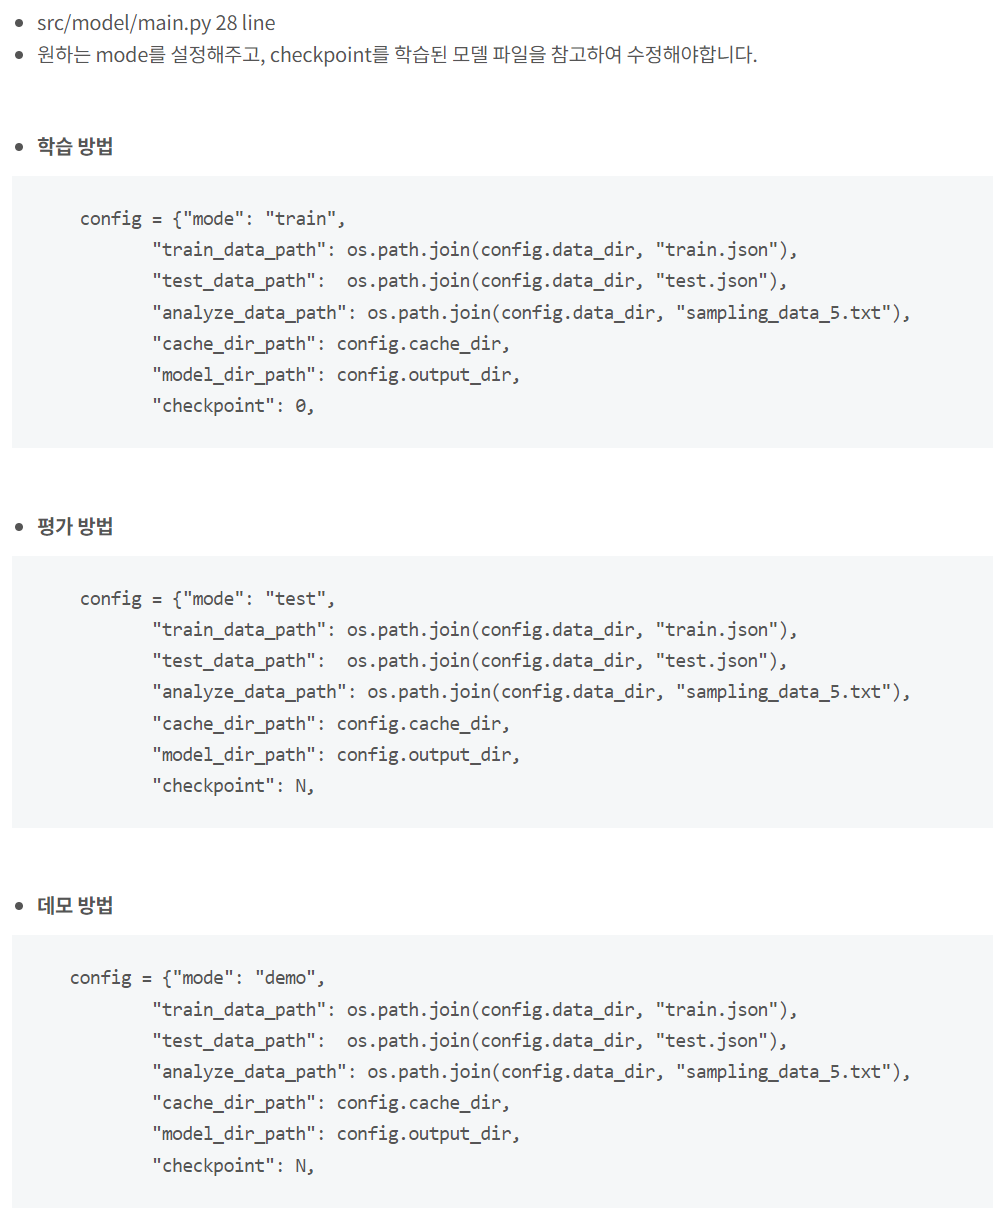

In [ ]:
if __name__ == "__main__":

    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    fine_vocab_path = os.path.join(data_dir, "fine_vocab.txt")
    coarse_vocab_path = os.path.join(data_dir, "coarse_vocab.txt")

    fine_vocab_map = {}
    coarse_vocab_map = {}

    with open(fine_vocab_path, 'r', encoding='utf-8') as vocab:
        for label in vocab:
            label = label.strip()
            fine_vocab_map[len(fine_vocab_map)] = label

    with open(coarse_vocab_path, 'r', encoding='utf-8') as vocab:
        for label in vocab:
            label = label.strip()
            coarse_vocab_map[len(coarse_vocab_map)] = label

    config = {"mode": "train",
              "train_data_path": data_dir + "/train.json",
              "test_data_path":  data_dir + "/test.json",
              "cache_dir_path": cache_dir,
              "model_dir_path": output_dir,
              "checkpoint": 0,
              "epoch": 5,
              "learning_rate": 1e-5,
              "dropout_rate": 0.3,
              "warmup_steps": 0,
              "max_grad_norm": 1.0,
              "batch_size": 8,
              "test_batch_size": 8,
              "max_length": 128,
              "lstm_hidden": 256,
              "lstm_num_layer": 1,
              "bidirectional_flag": True,
              "fine_tag": 9,
              "coarse_tag": 3,
              "fine_map": fine_vocab_map,
              "coarse_map": coarse_vocab_map,
              "gradient_accumulation_steps": 1,
              "weight_decay": 0.0,
              "adam_epsilon": 1e-8
    }

    helper = Helper(config)

    if config["mode"] == "train":
        helper.train()
    elif config["mode"] == "test":
        helper.test()
    elif config["mode"] == "demo":
        helper.demo()

토크나이저 불러오는 중...
토크나이저 불러오기 성공
korscibert 불러오는 중...


Some weights of the model checkpoint at /content/drive/MyDrive/kisti_baseline/pytorch_model.bin were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


korscibert 불러오기 성공


read_data: 140000it [00:02, 54480.85it/s]
convert_data2dataset: 100%|██████████| 140000/140000 [04:42<00:00, 495.30it/s]
read_data: 15740it [00:01, 12177.84it/s]
convert_data2dataset: 100%|██████████| 15740/15740 [00:31<00:00, 505.64it/s]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


['model.embeddings.word_embeddings.weight', 'model.embeddings.position_embeddings.weight', 'model.embeddings.token_type_embeddings.weight', 'model.embeddings.LayerNorm.weight', 'model.embeddings.LayerNorm.bias', 'model.encoder.layer.0.attention.self.query.weight', 'model.encoder.layer.0.attention.self.query.bias', 'model.encoder.layer.0.attention.self.key.weight', 'model.encoder.layer.0.attention.self.key.bias', 'model.encoder.layer.0.attention.self.value.weight', 'model.encoder.layer.0.attention.self.value.bias', 'model.encoder.layer.0.attention.output.dense.weight', 'model.encoder.layer.0.attention.output.dense.bias', 'model.encoder.layer.0.attention.output.LayerNorm.weight', 'model.encoder.layer.0.attention.output.LayerNorm.bias', 'model.encoder.layer.0.intermediate.dense.weight', 'model.encoder.layer.0.intermediate.dense.bias', 'model.encoder.layer.0.output.dense.weight', 'model.encoder.layer.0.output.dense.bias', 'model.encoder.layer.0.output.LayerNorm.weight', 'model.encoder.laye

do_train(epoch_1):   0%|          | 0/17500 [00:00<?, ?it/s]

	loss :  3.277545


do_train(epoch_1):   2%|▏         | 301/17500 [01:12<1:11:08,  4.03it/s]

	loss :  1.381672


do_train(epoch_1):   3%|▎         | 601/17500 [02:28<1:12:47,  3.87it/s]

	loss :  0.920935


do_train(epoch_1):   5%|▌         | 901/17500 [03:46<1:11:06,  3.89it/s]

	loss :  1.644093


do_train(epoch_1):   7%|▋         | 1201/17500 [05:03<1:09:53,  3.89it/s]

	loss :  1.278594


do_train(epoch_1):   9%|▊         | 1501/17500 [06:20<1:09:09,  3.86it/s]

	loss :  0.358049


do_train(epoch_1):  10%|█         | 1801/17500 [07:37<1:07:15,  3.89it/s]

	loss :  1.265780


do_train(epoch_1):  12%|█▏        | 2101/17500 [08:55<1:05:58,  3.89it/s]

	loss :  0.308422


do_train(epoch_1):  14%|█▎        | 2401/17500 [10:12<1:04:57,  3.87it/s]

	loss :  1.812021


do_train(epoch_1):  15%|█▌        | 2701/17500 [11:29<1:03:25,  3.89it/s]

	loss :  1.382062


do_train(epoch_1):  17%|█▋        | 3001/17500 [12:46<1:01:54,  3.90it/s]

	loss :  0.102417


do_train(epoch_1):  19%|█▉        | 3301/17500 [14:03<1:00:58,  3.88it/s]

	loss :  0.221210


do_train(epoch_1):  21%|██        | 3601/17500 [15:20<59:18,  3.91it/s]

	loss :  0.266277


do_train(epoch_1):  22%|██▏       | 3901/17500 [16:38<57:58,  3.91it/s]

	loss :  0.837633


do_train(epoch_1):  24%|██▍       | 4201/17500 [17:55<56:58,  3.89it/s]

	loss :  1.265991


do_train(epoch_1):  26%|██▌       | 4501/17500 [19:12<55:50,  3.88it/s]

	loss :  0.627298


do_train(epoch_1):  27%|██▋       | 4801/17500 [20:29<54:32,  3.88it/s]

	loss :  1.681176


do_train(epoch_1):  29%|██▉       | 5101/17500 [21:46<53:11,  3.89it/s]

	loss :  2.588109


do_train(epoch_1):  31%|███       | 5401/17500 [23:04<52:13,  3.86it/s]

	loss :  0.637276


do_train(epoch_1):  33%|███▎      | 5701/17500 [24:21<50:38,  3.88it/s]

	loss :  0.480773


do_train(epoch_1):  34%|███▍      | 6001/17500 [25:38<49:10,  3.90it/s]

	loss :  0.248838


do_train(epoch_1):  36%|███▌      | 6301/17500 [26:55<48:08,  3.88it/s]

	loss :  0.237699


do_train(epoch_1):  38%|███▊      | 6601/17500 [28:12<46:18,  3.92it/s]

	loss :  0.001593


do_train(epoch_1):  39%|███▉      | 6901/17500 [29:30<45:26,  3.89it/s]

	loss :  0.694325


do_train(epoch_1):  41%|████      | 7201/17500 [30:47<44:04,  3.90it/s]

	loss :  0.068391


do_train(epoch_1):  43%|████▎     | 7501/17500 [32:04<43:05,  3.87it/s]

	loss :  0.262913


do_train(epoch_1):  45%|████▍     | 7801/17500 [33:21<41:30,  3.89it/s]

	loss :  0.376558


do_train(epoch_1):  46%|████▋     | 8101/17500 [34:39<40:02,  3.91it/s]

	loss :  0.153644


do_train(epoch_1):  48%|████▊     | 8401/17500 [35:56<38:55,  3.90it/s]

	loss :  0.421040


do_train(epoch_1):  50%|████▉     | 8701/17500 [37:13<37:41,  3.89it/s]

	loss :  2.445020


do_train(epoch_1):  51%|█████▏    | 9001/17500 [38:30<36:24,  3.89it/s]

	loss :  0.234633


do_train(epoch_1):  53%|█████▎    | 9301/17500 [39:47<35:07,  3.89it/s]

	loss :  0.248255


do_train(epoch_1):  55%|█████▍    | 9601/17500 [41:05<33:59,  3.87it/s]

	loss :  0.119291


do_train(epoch_1):  57%|█████▋    | 9901/17500 [42:22<32:34,  3.89it/s]

	loss :  0.712565


do_train(epoch_1):  58%|█████▊    | 10201/17500 [43:39<31:22,  3.88it/s]

	loss :  0.497710


do_train(epoch_1):  60%|██████    | 10501/17500 [44:57<29:55,  3.90it/s]

	loss :  0.021108


do_train(epoch_1):  62%|██████▏   | 10801/17500 [46:14<28:43,  3.89it/s]

	loss :  0.371573


do_train(epoch_1):  63%|██████▎   | 11101/17500 [47:31<27:22,  3.90it/s]

	loss :  0.045964


do_train(epoch_1):  65%|██████▌   | 11401/17500 [48:48<26:16,  3.87it/s]

	loss :  0.753496


do_train(epoch_1):  67%|██████▋   | 11701/17500 [50:05<24:56,  3.88it/s]

	loss :  0.334284


do_train(epoch_1):  69%|██████▊   | 12001/17500 [51:23<23:32,  3.89it/s]

	loss :  0.009118


do_train(epoch_1):  70%|███████   | 12301/17500 [52:40<22:18,  3.89it/s]

	loss :  0.369343


do_train(epoch_1):  72%|███████▏  | 12601/17500 [53:57<21:01,  3.88it/s]

	loss :  0.397951


do_train(epoch_1):  74%|███████▎  | 12901/17500 [55:15<19:48,  3.87it/s]

	loss :  0.445498


do_train(epoch_1):  75%|███████▌  | 13201/17500 [56:32<18:31,  3.87it/s]

	loss :  2.344034


do_train(epoch_1):  77%|███████▋  | 13501/17500 [57:49<17:14,  3.87it/s]

	loss :  1.444194


do_train(epoch_1):  79%|███████▉  | 13801/17500 [59:06<15:55,  3.87it/s]

	loss :  1.050457


do_train(epoch_1):  81%|████████  | 14101/17500 [1:00:24<14:41,  3.86it/s]

	loss :  0.152512


do_train(epoch_1):  82%|████████▏ | 14401/17500 [1:01:41<13:19,  3.88it/s]

	loss :  0.676007


do_train(epoch_1):  84%|████████▍ | 14701/17500 [1:02:58<12:02,  3.88it/s]

	loss :  0.481242


do_train(epoch_1):  86%|████████▌ | 15001/17500 [1:04:15<10:42,  3.89it/s]

	loss :  0.003648


do_train(epoch_1):  87%|████████▋ | 15301/17500 [1:05:33<09:29,  3.86it/s]

	loss :  0.895389


do_train(epoch_1):  89%|████████▉ | 15601/17500 [1:06:50<08:06,  3.90it/s]

	loss :  0.971044


do_train(epoch_1):  91%|█████████ | 15901/17500 [1:08:07<06:51,  3.89it/s]

	loss :  0.186019


do_train(epoch_1):  93%|█████████▎| 16201/17500 [1:09:24<05:33,  3.89it/s]

	loss :  0.278043


do_train(epoch_1):  94%|█████████▍| 16501/17500 [1:10:42<04:15,  3.91it/s]

	loss :  0.333597


do_train(epoch_1):  96%|█████████▌| 16801/17500 [1:11:59<03:01,  3.86it/s]

	loss :  0.030978


do_train(epoch_1):  98%|█████████▊| 17101/17500 [1:13:16<01:42,  3.90it/s]

	loss :  0.152538


do_train(epoch_1):  99%|█████████▉| 17401/17500 [1:14:34<00:25,  3.89it/s]

	loss :  1.129233


do_train(epoch_1): 100%|██████████| 17500/17500 [1:14:59<00:00,  3.89it/s]


average_loss : 0.6987

train_coarse_accuracy :	0.942386	
train_coarse_precision :	0.933553	
train_coarse_recall :		0.937381	
train_coarse_f1 :			0.935342	

train_fine_accuracy :	0.840407	
train_fine_precision :	0.827423	
train_fine_recall :		0.839123	
train_fine_f1 :			0.831716	

train_coarse_fine_accuracy :	0.826257	


do_evaluate: 100%|██████████| 1312/1312 [02:33<00:00,  8.57it/s]


test_coarse_accuracy :	0.959339	
test_coarse_precision :	0.950957	
test_coarse_recall :		0.956483	
test_coarse_f1 :			0.953624	

test_fine_accuracy :	0.893329	
test_fine_precision :	0.902367	
test_fine_recall :		0.892645	
test_fine_f1 :			0.896812	

test_coarse_fine_accuracy :	0.891614	
max_test_coarse_f1 :		 0.953624
max_test_coarse_accuracy :		 0.959339
max_test_fine_f1 :		 0.896812
max_test_fine_accuracy :		 0.893329


do_train(epoch_2):   0%|          | 0/17500 [00:00<?, ?it/s]

	loss :  0.139690


do_train(epoch_2):   2%|▏         | 301/17500 [01:17<1:13:30,  3.90it/s]

	loss :  1.370194


do_train(epoch_2):   3%|▎         | 601/17500 [02:34<1:12:31,  3.88it/s]

	loss :  0.413573


do_train(epoch_2):   5%|▌         | 901/17500 [03:51<1:10:44,  3.91it/s]

	loss :  0.417893


do_train(epoch_2):   7%|▋         | 1201/17500 [05:08<1:09:36,  3.90it/s]

	loss :  0.936500


do_train(epoch_2):   9%|▊         | 1501/17500 [06:25<1:08:44,  3.88it/s]

	loss :  0.136209


do_train(epoch_2):  10%|█         | 1801/17500 [07:41<1:06:42,  3.92it/s]

	loss :  0.139631


do_train(epoch_2):  12%|█▏        | 2101/17500 [08:58<1:05:59,  3.89it/s]

	loss :  0.415644


do_train(epoch_2):  14%|█▎        | 2401/17500 [10:15<1:04:22,  3.91it/s]

	loss :  0.009827


do_train(epoch_2):  15%|█▌        | 2701/17500 [11:32<1:03:27,  3.89it/s]

	loss :  2.923464


do_train(epoch_2):  17%|█▋        | 3001/17500 [12:49<1:02:14,  3.88it/s]

	loss :  0.338011


do_train(epoch_2):  19%|█▉        | 3301/17500 [14:06<1:00:53,  3.89it/s]

	loss :  1.675021


do_train(epoch_2):  21%|██        | 3601/17500 [15:23<59:42,  3.88it/s]

	loss :  0.821941


do_train(epoch_2):  22%|██▏       | 3901/17500 [16:40<58:02,  3.90it/s]

	loss :  0.661585


do_train(epoch_2):  24%|██▍       | 4201/17500 [17:57<56:52,  3.90it/s]

	loss :  0.305150


do_train(epoch_2):  26%|██▌       | 4501/17500 [19:14<56:04,  3.86it/s]

	loss :  0.024307


do_train(epoch_2):  27%|██▋       | 4801/17500 [20:31<54:09,  3.91it/s]

	loss :  0.110218


do_train(epoch_2):  28%|██▊       | 4971/17500 [21:15<53:25,  3.91it/s]

In [ ]:
!nvidia-smi